Author: Pierre Brugière \\
EMAM: 16 05 2023 (for educational purpose only)

# Data Extraction.
In this program, the closing prices for the components of the GDAX 30 are extracted from "startinput" date until "endinput" date.
From these observations, a vector of expectation $M$ and a matrix  of variance-covariance $Covar$ for the average daily (price) returns are calculated. The vector $Mean\_A$ and matrix of variance-covariance $Covar\_A$ for these returns, annualised, are also calculated and will be used as input parameters to calculate the optimal portfolios with and without constraints. The data are extracted from yahoofinance.

First you need to install some Python libraries for data extraction from yahoo by running the code below.

In [1]:
!pip install yfinance

If all the calculations are executed correctly the "OK" message should appear after running the code below.

In [2]:
# Data Extraction
# Library importations
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import numpy as np


Tickers = ['DPW.DE','ALV.DE','BMW.DE','DTE.DE','FME.DE','BAS.DE',
        'HEN3.DE','LIN.F','SAP.DE','DBK.DE','BAYN.DE','VOW3.DE',
       'HEI.DE','FRE.F','MRK.DE','BEI.DE','SIE.DE','MUV2.DE',
      'DB1.DE','VNA.DE','EOAN.F','DAI.SG','ADS.DE',
      'RWE.DE','IFX.DE','1COV.DE','TKA.DE','CON.DE','LHA.DE']

startinput = '2017-01-01'
endinput = '2017-12-31'
S = pd.DataFrame() # create the data frame that will contain the data
for t in Tickers :
    #S[t] = web.DataReader(name = t, data_source='yahoo',start= startinput,end= endinput)['Close']
    S[t] = yf.Ticker(t).history(start=startinput,end=endinput)['Close']

# Calculation of the mean vector and variance-covariance matrix
R = pd.DataFrame()
Mean = pd.DataFrame()
Covar = pd.DataFrame()
R =S/S.shift(1)-1 # calculate the returns
R = R[1:] # eliminate the first raw which is undefined
Mean = R.mean() # calculate the mean vector
Covar = R.cov() # calculate the variance-covariance matrix

# Annualisation of the mean vector and variance-covariance matrix
Mean_A = pd.DataFrame()
Covar_A = pd.DataFrame()
n = len(R) # calculate the number of returns observed
d = len(Tickers)# calculate the number of stocks used
# Calculation of the average fraction of time (expressed in years) between two observations
Ys= int(startinput[0:4])
Ms= int(startinput[5:7])
Ds= int(startinput[8:10])
Ye= int(endinput[0:4])
Me= int(endinput[5:7])
De= int(endinput[8:10])
import datetime
startdate = datetime.date(Ys, Ms, Ds)
enddate = datetime.date(Ye, Me, De)
z=enddate-startdate
Duration = float(z.days) # calculate the number of calendar days between the two dates
m = float(len(R)-1)
delta = Duration/365/m # calculate the time interval, delta
Covar_A = Covar/delta # calculate the variance-covariance matrix on an annual basis
Mean_A = Mean/delta # calculate the mean vector on an annual basis
print ("OK Data extracted")

ERROR:yfinance:$DPW.DE: possibly delisted; no timezone found


OK Data extracted


## Checking a times series

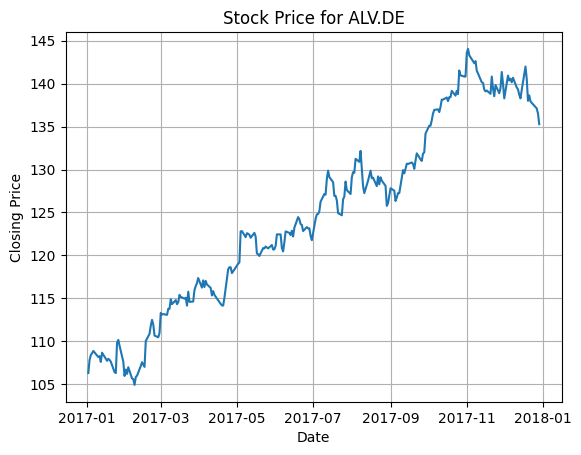

In [3]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt

# Define the stock ticker symbol and the date range
ticker = 'ALV.DE'  # Example ticker symbol for Apple Inc.
start_date = '2017-01-01'
end_date = '2017-12-31'

# Extract the time series data from Yahoo Finance
df = yf.Ticker(ticker).history(start=startinput,end=endinput)

# Plot the closing price
plt.plot(df.index, df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Stock Price for {}'.format(ticker))
plt.grid(True)
plt.show()

#Optimal Allocation.
The determmination of the Markowitz's optimal allocation is solved here with some additional constraints. As there is no explicit solution with these additional constraints, a solver is used which is called "qpsolvers" and which runs under Python 3.6. This solver can be added to Colab with the instruction "!pip install qpsolvers". The solutions found are compared with the solution of the problem without constraint (which is solved here with "qpsolvers" as well, even if an explicit formula exists).

More information about "qpsolvers" can be found at:

https://pypi.org/project/qpsolvers/

https://scaron.info/blog/quadratic-programming-in-python.html

https://web.stanford.edu/~boyd/papers/pdf/cvxpy_paper.pdf

In [4]:
!pip install qpsolvers # added for running on Colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 2.7 MB/s eta 0:00:00


## Allocation without various constraints.
The Markowitz's problem of finding the investment portfolio which presents the minimum risk for a given level of expectation $m$ is solved here for  $m=10\%$.

with solve the problem:
*   without constraints on the allocations
*   with constraints of positiveness for the allocations
*   with constraints of positiveness and 10% limits.


The program below can be run after running the "Data Extraction" program above.

https://qpsolvers.github.io/qpsolvers/quadratic-programming.html

In [5]:
# Optimal investment portfolio of risky assets with and without constraints
# import libraries
from numpy import array, dot
from qpsolvers import solve_qp
d=len(Mean)
m= 0.1 # expected return chosen here

P = array(2*Covar_A)
q = np.zeros(d)
A = array([Mean_A,[1]*d])
b =array([m,1])
lb = np.zeros((d, 1))  # min values for the allocations
ub= np.ones((d, 1))*.1


alloc_1=solve_qp(P, q, G=None, h=None, A=A, b=b, lb=None, ub=None, solver="cvxopt")
alloc_2=solve_qp(P, q, G=None, h=None, A=A, b=b, lb=None, ub=ub, solver="cvxopt")
alloc_3=solve_qp(P, q, G=None, h=None, A=A, b=b, lb=lb, ub=ub, solver="cvxopt")

Vec1=[1]*d
# brackets added for print for Python 3

print ("check alloc:", dot(alloc_1.T, Vec1),dot(alloc_2.T, Vec1),dot(alloc_3.T, Vec1))
mean_1=dot(alloc_1.T, Mean_A)
mean_2=dot(alloc_3.T, Mean_A)
mean_3=dot(alloc_1.T, Mean_A)
print ("check mean:", mean_1,dot(alloc_2.T, Mean_A),dot(alloc_3.T, Mean_A))
std_1=np.sqrt(dot(alloc_1.T, dot(P, alloc_1))/2)
std_2=np.sqrt(dot(alloc_2.T, dot(P, alloc_2))/2)
std_3=np.sqrt(dot(alloc_3.T, dot(P, alloc_3))/2)
print ("standard deviation:", std_1, std_2, std_3) # standard deviation
for i in range(d):
  print("{:<12s}: {:>8.2f}% {:>8.2f}% {:>8.2f}%".format(Tickers[i], 100 * alloc_1[i], 100 * alloc_2[i], 100 * alloc_3[i]))

check alloc: 0.9999999999999998 1.0000000000000002 1.0000000000000002
check mean: nan nan nan
standard deviation: nan nan nan
DPW.DE      :    94.26%    10.00%    10.00%
ALV.DE      :     6.31%     1.04%     0.00%
BMW.DE      :    -2.91%     6.72%     3.47%
DTE.DE      :    -2.63%    10.00%    10.00%
FME.DE      :     0.34%     0.48%     0.01%
BAS.DE      :    -1.07%    -2.87%     0.00%
HEN3.DE     :    -5.75%     3.17%     4.87%
LIN.F       :     1.00%     9.15%     9.34%
SAP.DE      :    -0.96%     6.06%     0.65%
DBK.DE      :    -0.79%    -2.29%     0.00%
BAYN.DE     :     2.13%    -0.42%     0.00%
VOW3.DE     :     1.31%    -0.62%     0.00%
HEI.DE      :     0.96%     2.47%     0.44%
FRE.F       :    -3.84%    -0.07%     0.46%
MRK.DE      :    -1.81%     9.42%     9.92%
BEI.DE      :     3.14%     5.19%     4.92%
SIE.DE      :    -1.54%    -5.07%     0.00%
MUV2.DE     :    -1.71%    10.00%    10.00%
DB1.DE      :     1.85%     8.67%     6.83%
VNA.DE      :     5.05%    10.00%    1

## Optimal allocation with positiveness constraints, $10\%$ limit and correlation adjustements.
The problem of finding the investment portfolio which presents the minimum risk for a given level of expectation $m$ is solved here for $m=10\%$. To take into account the uncertainty of the variance-covariance estimates, all the diagonal terms of the variance_covariance matrix are multiplied by the factor $1.1^2$. By doing so, all estimated correlations are divided by a factor $1.1$.

In [6]:
!pip install qpsolvers # added for running on Colab

In [7]:
# Allocations with constraints of positiveness and 10% limit, with 10% shrinkage
# Ref1: https://pypi.org/project/qpsolvers/
# Ref2: https://scaron.info/blog/quadratic-programming-in-python.html
# Ref3: https://web.stanford.edu/~boyd/papers/pdf/cvxpy_paper.pdf

from numpy import array, dot
from qpsolvers import solve_qp

m= 0.1 # expected return chosen here

Covar_B = pd.DataFrame()
Covar_B = Covar_A.copy()
for x in Tickers:
    Covar_B[x][x] = (1.1**2)*Covar_B[x][x]

P = array(2*Covar_A)
q = np.zeros(d)
A = array([Mean_A,[1]*d])
b =array([m,1])
lb = np.zeros((d, 1))  # min values for the allocations
ub= np.ones((d, 1))*.1


alloc_1=solve_qp(P, q, G=None, h=None, A=A, b=b, lb=None, ub=None, solver="cvxopt")
alloc_2=solve_qp(P, q, G=None, h=None, A=A, b=b, lb=None, ub=ub, solver="cvxopt")
alloc_3=solve_qp(P, q, G=None, h=None, A=A, b=b, lb=lb, ub=ub, solver="cvxopt")

Vec1=[1]*d
# brackets added for print for Python 3

print ("check alloc:", dot(alloc_1.T, Vec1),dot(alloc_2.T, Vec1),dot(alloc_3.T, Vec1))
mean_1=dot(alloc_1.T, Mean_A)
mean_2=dot(alloc_3.T, Mean_A)
mean_3=dot(alloc_1.T, Mean_A)
print ("check mean:", mean_1,dot(alloc_2.T, Mean_A),dot(alloc_3.T, Mean_A))
std_1=np.sqrt(dot(alloc_1.T, dot(P, alloc_1))/2)
std_2=np.sqrt(dot(alloc_2.T, dot(P, alloc_2))/2)
std_3=np.sqrt(dot(alloc_3.T, dot(P, alloc_3))/2)
print ("standard deviation:", std_1, std_2, std_3) # standard deviation
for i in range(d):
  print("{:<12s}: {:>8.2f}% {:>8.2f}% {:>8.2f}%".format(Tickers[i], 100 * alloc_1[i], 100 * alloc_2[i], 100 * alloc_3[i]))

check alloc: 0.9999999999999998 1.0000000000000002 1.0000000000000002
check mean: nan nan nan
standard deviation: nan nan nan
DPW.DE      :    94.26%    10.00%    10.00%
ALV.DE      :     6.31%     1.04%     0.00%
BMW.DE      :    -2.91%     6.72%     3.47%
DTE.DE      :    -2.63%    10.00%    10.00%
FME.DE      :     0.34%     0.48%     0.01%
BAS.DE      :    -1.07%    -2.87%     0.00%
HEN3.DE     :    -5.75%     3.17%     4.87%
LIN.F       :     1.00%     9.15%     9.34%
SAP.DE      :    -0.96%     6.06%     0.65%
DBK.DE      :    -0.79%    -2.29%     0.00%
BAYN.DE     :     2.13%    -0.42%     0.00%
VOW3.DE     :     1.31%    -0.62%     0.00%
HEI.DE      :     0.96%     2.47%     0.44%
FRE.F       :    -3.84%    -0.07%     0.46%
MRK.DE      :    -1.81%     9.42%     9.92%
BEI.DE      :     3.14%     5.19%     4.92%
SIE.DE      :    -1.54%    -5.07%     0.00%
MUV2.DE     :    -1.71%    10.00%    10.00%
DB1.DE      :     1.85%     8.67%     6.83%
VNA.DE      :     5.05%    10.00%    1

<ipython-input-7-101ab66b6588>:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Covar_B[x][x] = (1.1**2)*Covar_B[x][x]


# VaR of a Portfolio.
In this section the **VaR** of a portfolio is calculated with two different methods, based on the observations of the daily returns of the portfolio. In the first method, the **VaR** is calculated for a normal law having the same mean and variance as the portfolio. In the second method, the **VaR** is calculated according to the **bootstrap** method.

## Data Extraction
Here the historical prices for 5 stocks are extracted from "startinput" date to "endinput" date. Then a portfolio is considered for which each stock has the same weight at inception. For this portfolio, the histogram of the daily returns is calculated over the period $[startinput\_date,  endinput\_date]$. For this portfolio, the Skew and Kurtosis of the returns and the statistics of the Bera-Jarque's test are calculated to test the hypothesis of normality.

ERROR:yfinance:$DPW.DE: possibly delisted; no timezone found
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

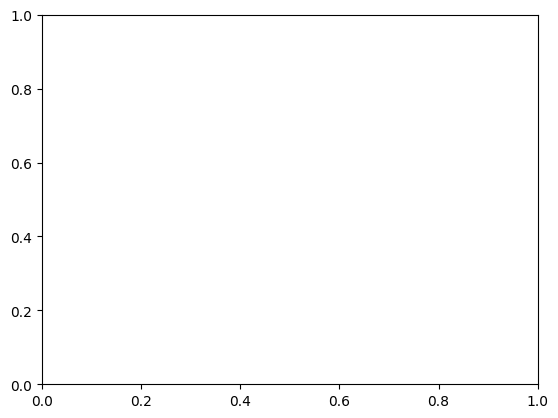

In [8]:
#### Import Packages
import pandas as pd
import numpy as np
import math
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew
from scipy.stats import kurtosis
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
##################################################################
###                     Data Extraction                        ###
##################################################################
Tickers = ['DPW.DE','ALV.DE', 'BMW.DE', 'BAS.DE', 'FME.DE']
# Define the observation period
startinput = '2017-01-1'
endinput = '2017-12-31'
S = pd.DataFrame() # Create the Dataframe that will contain the prices observed
for t in Tickers :
    #S[t] = web.DataReader( name = t, data_source = 'yahoo', start = startinput, end = endinput)['Close']
    S[t] = yf.Ticker(t).history(start=startinput,end=endinput)['Close']
# one row per date
# one column per stock
# To save the data on pc : S.to_csv('C:/Users/Me/Documents/data.csv')
##################################################################
###               Asset Returns Computation                    ###
##################################################################
R = pd.DataFrame() # dataframe that will contains the stocks returns
# Calculating the stocks daily returns
for t in Tickers :
    R[t] = S[t]/S[t].shift(1) - 1
R = R[1:] # Eliminates the first row
##################################################################
###                   Allocation                               ###
##################################################################
d = len(Tickers) # number of stocks considered
# define the weight of each stock in the portfolio : arbitrary choice
w = np.zeros(d)
for i in range(d):
    w[i] = 1.0/d
##################################################################
###                     Portfolio returns                      ###
##################################################################
R_ptf = R.dot(w) # Compute the daily return of the portfolio
##################################################################
###               Histogramm & Normality test                  ###
##################################################################
## parameters of the normal curve
meanR = np.mean(R_ptf)
sdevR = np.std(R_ptf)
minR  = np.min(R_ptf)
maxR  = np.max(R_ptf)
x     = np.linspace(minR, maxR, 100)

##plot
plt.hist(R_ptf, edgecolor = 'black', bins=15)
plt.plot(x,norm.pdf(x,meanR,sdevR))
plt.grid(True)
plt.xlabel('Range Daily Returns')
plt.ylabel('Number of observations')
plt.show()

## Bera-Jarque test
skewnessR       = skew(R_ptf)
excesskurtosisR = kurtosis(R_ptf, fisher=True)
n               = len(R_ptf)
bj              = (n/6) * (skewnessR**2) + (n/24) * (excesskurtosisR**2)
chi2quantile    = stats.chi2.ppf(0.95, df=2)
print ("Bera-Jarque statistics:",bj)
print ("quantile 95%:", chi2quantile)
if bj > chi2quantile : print ("Normality assumption rejected")
else : print ("Normality assumption accepted")

In [ ]:
print(excesskurtosisR)

## Calculation of the **VaR** 99% under the Gaussian hypothesis.
Here the  **VaR** 99% is calculated with the formula for normal returns, using the expected mean and variance of the portfolio over the observation period.

In [ ]:
##################################################################
###              VaR calculation for a Gaussian law     ###
##################################################################
mean1 = np.mean(R_ptf)
var1  = np.std(R_ptf, ddof = 1)**2
# Value at risk
VaR_99_1d = norm.ppf(1-0.99, mean1,  math.sqrt(var1))
VaR_99_10d = norm.ppf(1-0.99, mean1*10,  math.sqrt(10*var1))
print('Daily VaR 99% :   ', "{0:.3f}%".format(100*VaR_99_1d))
print('10 business days VaR 99% :   ', "{0:.3f}%".format(100*VaR_99_10d))

## Bootstrap Historical VaR Simulation (BHVS)
Here the **VaR** of the portfolio is calculated by simulations. The **VaR** is calculated over a 10 business days period by simulating 10 successive vectors of daily returns for the components of the portfolio. These 10 successive vectors of daily retuns are generated according to the Bootstrap method, by picking with replacement 10 vectors of returns from the series of vectors of daily returns, calculated from "startdate" to "end date". So basically, the Bootstrap method is a Monte Carlo method applied to an empirical probability. The calculation of the **BHVS** is made here for the portfolio of 5 stocks from the GDAX 30 for which the data have been extracted above.

In [ ]:
##################################################################
###             BHS VaR for the portfolio                      ###
##################################################################

# n vectors of daily returns for the stocks are observed
# the VaR of the portfolio is calculated for a p business days period.
# s simulations for p days returns are calculated
# in each simulation, p vectors of stocks returns are chosen with replacement amonstg n.

n = len(R.index) # number of returns per stock observed
p = 10 # number of daily returns considered in each bootstrap simulation
s = 10000 # number of bootstrap simulations

# output of the bootstrap : array where at each simulation the return over p days is saved
perf = np.zeros(s)

## Bootstrap
for i in range(s):
    #select with replacement p vector of returns among the n vectors of the sample
    idx = np.random.choice(n,p)
    # extract the corresponding vectors in the dataset
    RB = R.iloc[idx]
    # Calculate the returns over the p days for each stock
    RBP = np.prod(RB+1) - 1
    # save the return of the portfolio over the p days
    perf[i] = RBP.dot(w)

### Histogram of the p business days returns simulated
plt.hist(perf,30 ,histtype='step')
plt.grid(True)

# Calculation of the VaR from the simulated returns
var = np.percentile(perf,1-0.99)
print("The 10 business days VaR 99% is :", round(var*100,2), "%")

# Security Market Line

## Using the Tangent Portfolio

In [ ]:
# Library importations
import pandas as pd
import yfinance as yf
import numpy as np
import math
from numpy import linalg as LA
from numpy.linalg import inv
from scipy import stats
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

r=0 # risk-free rate

# Data extraction
data = pd.Series()
TickerDax = ['DPW.DE','ALV.DE','BMW.DE','DTE.DE','FME.DE','BAS.DE',
        'HEN3.DE','LIN.F','SAP.DE','DBK.DE','BAYN.DE','VOW3.DE',
       'HEI.DE','FRE.F','MRK.DE','BEI.DE','SIE.DE','MUV2.DE',
      'DB1.DE','VNA.DE','EOAN.F','DAI.SG','ADS.DE',
      'RWE.DE','IFX.DE','1COV.DE','TKA.DE','CON.DE','LHA.DE']
n_TickerDax = len(TickerDax) # nb of stocks considered

for x in TickerDax :
    data[x] = yf.Ticker(x).history(start='2017-01-1',end='2017-12-31')

# Variable creations
AFactor = len(data['DPW.DE'])-1 # annualisation factor, based on number of observations in a year
Vec1 = np.linspace(1, 1, n_TickerDax) # create a vector, with all components equal to 1
data_R = pd.DataFrame() # daily returns
Mdata_R = pd.DataFrame() # means of the daily returns
Sigma = pd.DataFrame() # variance-covariance matrix of the returns annualised
Sigma_diag = pd.DataFrame() # individual variances (derived from the variance-covariance matrix)

for x in TickerDax:
    data_R[x] = (data[x]['Close']/data[x]['Close'].shift(1)-1)
Sigma = AFactor*data_R.cov() # annualisation, the missing values are not taken into account with .Cov()
InvSigma = inv(Sigma)
for x in TickerDax:
    Sigma_diag[x] = [Sigma[x][x]]
    Mdata_R[x]= [float(np.mean(data_R[x])) ]

# Model parameters, derived from the observations
Mean =  AFactor* Mdata_R.iloc[0] # average returns on an annualised basis
STD = Sigma_diag.iloc[0]**.5 # standard deviations on an annualised basis

# Important variables calculation
a = Vec1.T.dot(InvSigma).dot(Vec1)
b = Mean.T.dot(InvSigma).dot(Vec1)
sd_a = 1 / math.sqrt(a) # standard deviation, minimum variance portfolio
m_a = b / a # expected return, minimum variance portfolio
m_w = math.sqrt((Mean - b/a * Vec1).T.dot(InvSigma).dot(Mean - b/a * Vec1)) # expected return, portfolio w
m_r = math.sqrt((Mean - r * Vec1).T.dot(InvSigma).dot(Mean - r * Vec1)) # expected return, Tangent Portfolio

# Graph plot
np.random.seed(7777) # Fixing random state for reproducibility
colors = np.random.rand(len(STD)) # each point will have its own (random) color
plt.scatter(STD, Mean, c=colors, alpha=0.7) # plot the assets, alpha transparency parameter
ax.annotate(TickerDax[0], (STD[0]+.01,Mean[0] ))
ax.annotate(TickerDax[1], (STD[1]+.01,Mean[1] ))
ax.annotate(TickerDax[2], (STD[2]+.01,Mean[2] ))
ax.annotate(TickerDax[3], (STD[3]+.01,Mean[3]-.01 ))
ax.annotate(TickerDax[4], (STD[4]+.01,Mean[4] ))
range_inf = np.min(Mean) - 0.05
range_sup = np.max(Mean) + 0.35
z2 = np.linspace(range_inf , range_sup, 50) # range of expected returns considered
z1 = pd.DataFrame()
z= pd.DataFrame()
zr= pd.DataFrame()
i=0
for i in range(len(z2)):
    z1[i]= [math.sqrt( ((z2[i]- m_a)/m_w)**2 + sd_a**2 )] # Frontier
    z[i]= [(z2[i] - b/a)/m_w] # Asymptot to the Frontier
    zr[i]= [(z2[i] - r)/m_r] # Capital Marlet Line
z1 = z1.iloc[0]
z=z.iloc[0]
zr=zr.iloc[0]
plt.plot(z1, z2, alpha=1) # plot the Frontier # print deleted in Python 3
plt.plot(z, z2, alpha=1) # plot the asymptot to the Frontier # print deleted in Python 3
plt.plot(zr, z2, alpha=1) # plot the Capital Market Line # print deleted in Python 3
plt.legend(['Capital Market Line','Frontier','Asymptot', ], loc=2)
plt.grid(True)
plt.xlabel('Annualised standard deviation')
plt.ylabel('Annualised return')
plt.show()

# Useful Ouputs # bracket added around the print for Python 3
print ("annualised standard deviations of the returns:")
print (STD)
print ("annualised means of the returns:")
print (Mean)
print ("min variance portfolio:")
print ("sd_a", sd_a, ",m_a", b/a)
#print ("matrix of variance-covariance:")
#print (Sigma)
#print ("Correl Matrix")
#print (data_R . corr ())

# to see the DAX, add below "plt.ylabel('Annualised return')" the code
DAX = yf.Ticker(x).history(start='2017-01-1',end='2017-12-31')
Dax_R= (DAX['Close']/DAX['Close'].shift(1)-1)
DaxFactor = len(Dax_R)
Dax_mean = np.mean(Dax_R)*DaxFactor
Dax_std = np.std(Dax_R)*np.sqrt(DaxFactor)
ax.scatter(Dax_std, Dax_mean)
ax.annotate("DAX", (Dax_std,Dax_mean ))
# for a better visibility of the asymptot change the range
#range_inf = np.min(Mean) - 0.5
#range_sup = np.max(Mean) + 1.5

In [ ]:
# Calculation Tangent Portfolio r_0=0
pi_T=InvSigma.dot(Mean)/b # allocation of the Tangent Portfolio
print("allocation Tangent Portfolio:",pi_T)
print("verification:",pi_T.T.dot(Vec1)) # verification sum of the allocation is 1
Cov_T=Sigma.dot(pi_T) # covariances of the assets with R_T
v_T= pi_T.dot(Sigma).dot(pi_T)# variance of R_T
m_T= pi_T.T.dot(Mean) # return R_T
beta_T=Cov_T/v_T # beta of the 29 stocks relatively to the tangent portfolio
print("Vol Tangent Portfolio:",np.sqrt(v_T))
print("Return Tangent Portfolio:",m_T)

fig, ax = plt.subplots()
np.sqrt(v_T)
y=Mean
x=beta_T
plt.scatter(x, y,alpha=0.7)
plt.scatter(1, m_T,alpha=0.7)
ax.annotate("Tgt", (1,m_T))
plt.xlabel('beta')
plt.ylabel('return')
plt.suptitle('SML illustration')
plt.show()

## Using The Market Portfolio as a proxy

In [ ]:
# Data Extraction
# Library importations
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import numpy as np

startinput = '2017-01-01'
endinput = '2017-12-31'

Ref = '^GDAXI' # the betas are calculated relatively to Ref.
Tickers = ['DPW.DE','ALV.DE','BMW.DE','DTE.DE','FME.DE','BAS.DE',
        'HEN3.DE','LIN.F','SAP.DE','DBK.DE','BAYN.DE','VOW3.DE',
       'HEI.DE','FRE.F','MRK.DE','BEI.DE','SIE.DE','MUV2.DE',
      'DB1.DE','VNA.DE','EOAN.F','DAI.SG','ADS.DE',
      'RWE.DE','IFX.DE','1COV.DE','TKA.DE','CON.DE','LHA.DE',Ref]

S = pd.DataFrame() # create the data frame that will contain the data
for t in Tickers :
    S[t] = yf.Ticker(t).history(start=startinput,end=endinput)['Close']

# Calculation of the mean vector and variance-covariance matrix
R = pd.DataFrame()
Mean = pd.DataFrame()
Covar = pd.DataFrame()
R =S/S.shift(1)-1 # calculate the returns
R = R[1:] # eliminate the first raw which is undefined
Mean = R.mean() # calculate the mean vector
Covar = R.cov() # calculate the variance-covariance matrix

# Annualisation of the mean vector and variance-covariance matrix
Mean_A = pd.DataFrame()
Covar_A = pd.DataFrame()
n = len(R) # calculate the number of returns observed
d = len(Tickers)# calculate the number of stocks used
# Calculation of the average fraction of time (expressed in years) between two observations
Ys= int(startinput[0:4])
Ms= int(startinput[5:7])
Ds= int(startinput[8:10])
Ye= int(endinput[0:4])
Me= int(endinput[5:7])
De= int(endinput[8:10])
import datetime
startdate = datetime.date(Ys, Ms, Ds)
enddate = datetime.date(Ye, Me, De)
z=enddate-startdate
Duration = float(z.days) # calculate the number of calendar days between the two dates
m = float(len(R)-1)
delta = Duration/365/m # calculate the time interval, delta
Covar_A = Covar/delta # calculate the variance-covariance matrix on an annual basis
Mean_A = Mean/delta # calculate the mean vector on an annual basis
print ("OK Data extracted")



#### Calculation of the betas ####
beta = pd.DataFrame()
i=0
for t in Tickers :
  beta[t]= [Covar_A.values[i,29]/Covar_A.values[29,29]]
  i=i+1
###################################
import matplotlib.pyplot as plt
fig, ax = plt.subplots()


#### scattering beta/returns for the points ####
y=Mean_A
x=beta.mean()
plt.scatter(x, y,alpha=0.7)
plt.scatter(x[29], y[29],c='r')
plt.suptitle('SML illustration')
plt.xlabel('beta')
plt.ylabel('return')
ax.annotate("DAX", (x[29],y[29]))

##### Optionalities for the graph ####
plt.grid(True)
#plt.ylim(-0.2, 0.9)
#plt.xlim(0, 2)
#c=colors, alpha=0.7

#### SML with r_0=0 and Ref = DAX ####
range_inf = x.min()
range_sup = x.max()
SML_x = np.linspace(range_inf , range_sup, 50) # range of expected returns considered
SML_y = SML_x*y[29]/x[29]
plt.plot(SML_x, SML_y,alpha=1,c='b')
#######################################
plt.show()